# Zillow Prediction 2017
## Goals:
* Construct an ML Regression model that predicts propery tax assessed values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties.

* Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.

* Make recommendations on what works or doesn't work in predicting these homes' values.

* Other key drivers:

## Imports

In [1]:
# necessary imports
import numpy as np
import os
import seaborn as sns
import scipy.stats as stat
from scipy.stats import pearsonr
from scipy.stats import pointbiserialr
import pandas as pd
import matplotlib.pyplot as plt
from pydataset import data
import warnings
warnings.filterwarnings("ignore")

import wrangle as wra
import env
import explore as exp
import evaluate as ev

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
from math import sqrt
import statsmodels.api as sm

from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor

## Acquire
* Data is pulled from Zillow dataset tables (properties_2017, predictions_2017) joined in SQL with a function updating to CSV in case of disconnection
* Includes only single family homes ('261' code) and 2017 transactions
* Contains 52441 rows with 8 columns
* Each row is a home/property
* Each column is a home feature

## Prepare

* stripped and renamed all columns appropriately for easy recall
* All nulls in rows deleted in data except 'garagecarcnt' where nulls equals '0'
* changed some floats to integers
* target value 'taxvalue' is continuous float
* handled outliers for better distribution and visuals
* created dummie columns for the three counties

## Data Dictionary

| Features     | Definition                                                                                                           | Unit        |
|--------------|----------------------------------------------------------------------------------------------------------------------|-------------|
| taxvalue     | Assessed tax value of the home.                                                                                      | US Dollar   |
| bedroomcnt   | Number of bedrooms in home.                                                                                          |             |
| bathroomcnt  | Number of bathrooms in home including half baths.                                                                    |             |
| finished_sf  | Total of square feet in the finished home.                                                                           | Square Feet |
| garagecarcnt | Number of car spots in garage.                                                                                       |             |
| lotsize_sf   | Total of square feet for the property or lot.                                                                        | Square Feet |
| yearbuilt    | Year the home's build.                                                                                               |             |
| county       | County in which the property resides. a.k.a 'fips' 6037=Los Angeles County, 6059=Orange County,  6111=Ventura County |             |

In [2]:
# build query and look at data
zillow_query = """
        select bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, garagecarcnt, lotsizesquarefeet, yearbuilt, fips
        from properties_2017
        join predictions_2017 using (parcelid)
        where propertylandusetypeid = '261'
        AND YEAR(transactiondate) = 2017;
        """

df = wra.get_zillow_data(zillow_query)

df.head()

,Unnamed: 0,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,garagecarcnt,lotsizesquarefeet,yearbuilt,fips
0,0,4.0,3.5,3100.0,1023282.0,2.0,4506.0,1998.0,6059.0
1,1,2.0,1.0,1465.0,464000.0,1.0,12647.0,1967.0,6111.0
2,2,3.0,2.0,1243.0,564778.0,2.0,8432.0,1962.0,6059.0
3,3,4.0,3.0,2376.0,145143.0,NaN,13038.0,1970.0,6037.0
4,4,4.0,3.0,2962.0,773303.0,NaN,63000.0,1950.0,6037.0


In [3]:
# see if the rows are the desired 52K
df.shape

(52441, 9)

In [4]:
#rename columns
df.rename(columns={'calculatedfinishedsquarefeet': 'finished_sf', 'taxvaluedollarcnt': 'taxvalue', 'lotsizesquarefeet': 'lotsize_sf', 'fips': 'county'}, inplace=True)

## A brief look at the data

In [5]:
df = df.drop('Unnamed: 0', axis=1)
df.head()

,bedroomcnt,bathroomcnt,finished_sf,taxvalue,garagecarcnt,lotsize_sf,yearbuilt,county
0,4.0,3.5,3100.0,1023282.0,2.0,4506.0,1998.0,6059.0
1,2.0,1.0,1465.0,464000.0,1.0,12647.0,1967.0,6111.0
2,3.0,2.0,1243.0,564778.0,2.0,8432.0,1962.0,6059.0
3,4.0,3.0,2376.0,145143.0,NaN,13038.0,1970.0,6037.0
4,4.0,3.0,2962.0,773303.0,NaN,63000.0,1950.0,6037.0


In [6]:
# look at our dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedroomcnt    52441 non-null  float64
 1   bathroomcnt   52441 non-null  float64
 2   finished_sf   52359 non-null  float64
 3   taxvalue      52440 non-null  float64
 4   garagecarcnt  18015 non-null  float64
 5   lotsize_sf    52072 non-null  float64
 6   yearbuilt     52325 non-null  float64
 7   county        52441 non-null  float64
dtypes: float64(8)
memory usage: 3.2 MB


## A summary of the data

In [7]:
# change all NaNs to '0' in 'garagecarcnt' column
df['garagecarcnt'] = df['garagecarcnt'].fillna(0)

In [8]:
df.head()

,bedroomcnt,bathroomcnt,finished_sf,taxvalue,garagecarcnt,lotsize_sf,yearbuilt,county
0,4.0,3.5,3100.0,1023282.0,2.0,4506.0,1998.0,6059.0
1,2.0,1.0,1465.0,464000.0,1.0,12647.0,1967.0,6111.0
2,3.0,2.0,1243.0,564778.0,2.0,8432.0,1962.0,6059.0
3,4.0,3.0,2376.0,145143.0,0.0,13038.0,1970.0,6037.0
4,4.0,3.0,2962.0,773303.0,0.0,63000.0,1950.0,6037.0


In [9]:
# drop all null rows
df.dropna(inplace=True)

In [10]:
# see how many rows we lost (452)
df.shape

(51959, 8)

In [11]:
#verify if any nulls in columns
df.isnull().sum()

bedroomcnt      0
bathroomcnt     0
finished_sf     0
taxvalue        0
garagecarcnt    0
lotsize_sf      0
yearbuilt       0
county          0
dtype: int64

In [12]:
# change some floats to integers for brevity
df[['bedroomcnt', 'finished_sf', 'taxvalue', 'garagecarcnt', 'lotsize_sf', 'yearbuilt', 'county']] = df[['bedroomcnt', 'finished_sf', 'taxvalue', 'garagecarcnt', 'lotsize_sf', 'yearbuilt', 'county']].astype(int)

In [13]:
# verify Dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51959 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedroomcnt    51959 non-null  int64  
 1   bathroomcnt   51959 non-null  float64
 2   finished_sf   51959 non-null  int64  
 3   taxvalue      51959 non-null  int64  
 4   garagecarcnt  51959 non-null  int64  
 5   lotsize_sf    51959 non-null  int64  
 6   yearbuilt     51959 non-null  int64  
 7   county        51959 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 3.6 MB


In [14]:
df.head()

,bedroomcnt,bathroomcnt,finished_sf,taxvalue,garagecarcnt,lotsize_sf,yearbuilt,county
0,4,3.5,3100,1023282,2,4506,1998,6059
1,2,1.0,1465,464000,1,12647,1967,6111
2,3,2.0,1243,564778,2,8432,1962,6059
3,4,3.0,2376,145143,0,13038,1970,6037
4,4,3.0,2962,773303,0,63000,1950,6037


In [15]:
# change 'fips' codes to names of 'county'
df.county = df.county.map({6037:'LA',6059:'Orange',6111:'Ventura'})

In [16]:
df.head()

,bedroomcnt,bathroomcnt,finished_sf,taxvalue,garagecarcnt,lotsize_sf,yearbuilt,county
0,4,3.5,3100,1023282,2,4506,1998,Orange
1,2,1.0,1465,464000,1,12647,1967,Ventura
2,3,2.0,1243,564778,2,8432,1962,Orange
3,4,3.0,2376,145143,0,13038,1970,LA
4,4,3.0,2962,773303,0,63000,1950,LA


In [17]:
# shrinking outliers
df = df [df.finished_sf < 25_000]
df = df[df.lotsize_sf < 76_000]
df = df [df.taxvalue < df.taxvalue.quantile(.95)].copy()
df = df[df.taxvalue > df.taxvalue.quantile(.001)].copy()

In [18]:
df.shape

(48866, 8)

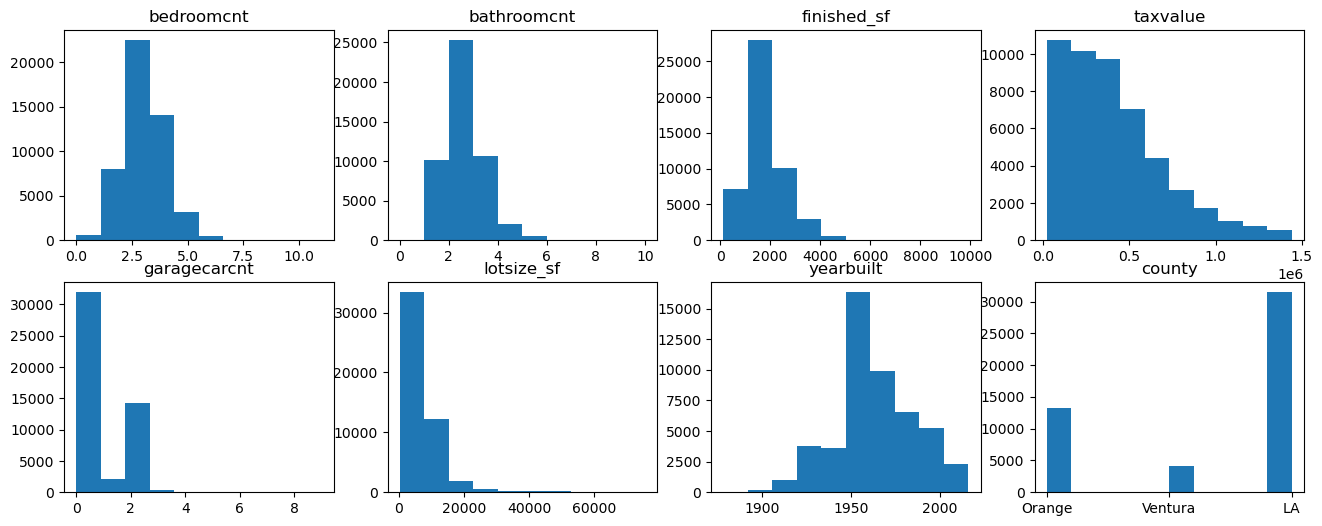

In [19]:
# show histogram of all features
ev.plot_hist_subplots(df)

bedroomcnt


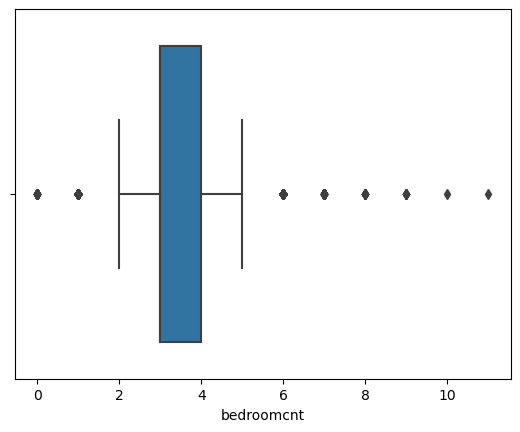

0        48
1       533
2      8047
3     22483
4     14060
5      3174
6       438
7        66
8         9
9         6
10        1
11        1
Name: bedroomcnt, dtype: int64

bathroomcnt


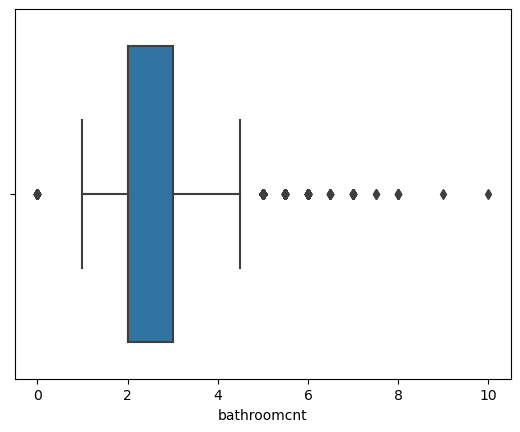

0.0        34
1.0      9350
1.5       826
2.0     21413
2.5      3860
3.0      9954
3.5       753
4.0      1647
4.5       443
5.0       410
5.5        68
6.0        76
6.5         8
7.0        15
7.5         2
8.0         5
9.0         1
10.0        1
Name: bathroomcnt, dtype: int64

finished_sf


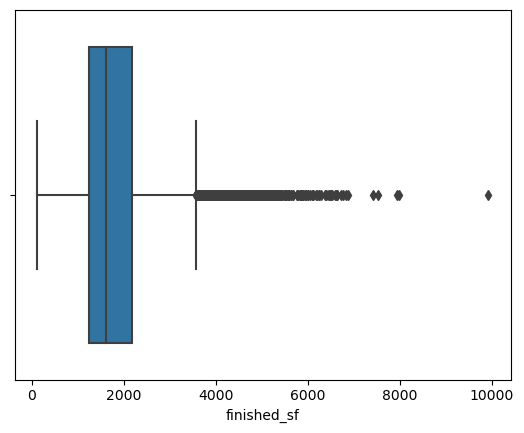

128     1
152     1
240     1
280     1
288     1
       ..
7416    1
7524    1
7942    1
7970    1
9918    1
Name: finished_sf, Length: 3875, dtype: int64

taxvalue


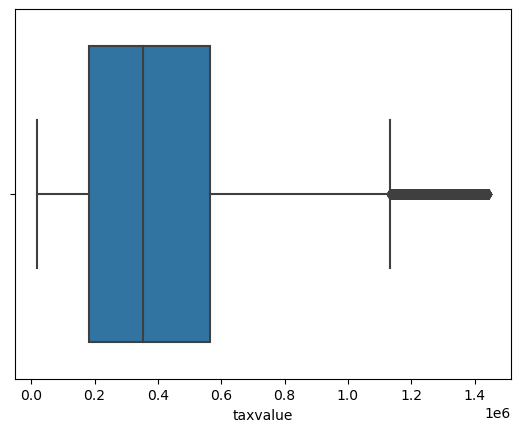

19616      2
19624      1
19822      1
19833      1
20031      1
          ..
1443000    1
1443002    1
1443004    1
1443005    1
1443484    1
Name: taxvalue, Length: 35937, dtype: int64

garagecarcnt


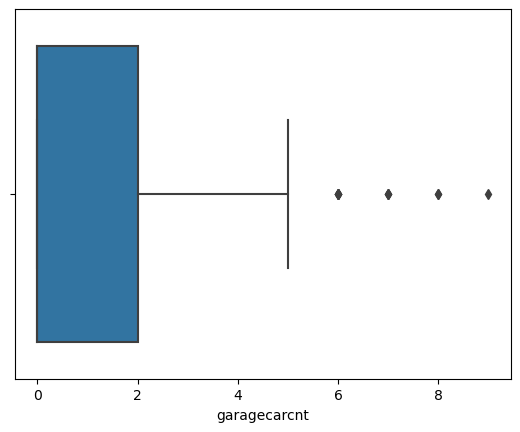

0    31946
1     2127
2    14210
3      443
4      111
5       18
6        5
7        3
8        2
9        1
Name: garagecarcnt, dtype: int64

lotsize_sf


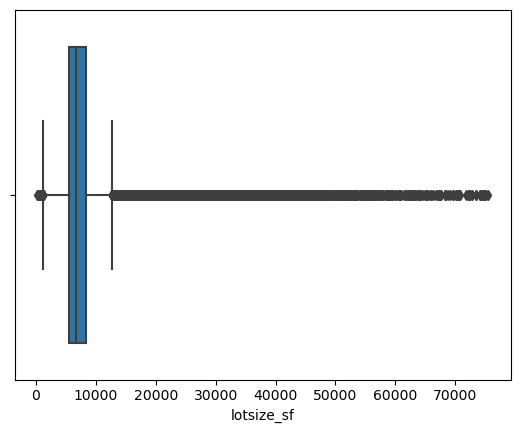

236      1
480      1
540      8
592      1
594      1
        ..
74764    1
74805    1
74922    1
75151    1
75515    1
Name: lotsize_sf, Length: 12835, dtype: int64

yearbuilt


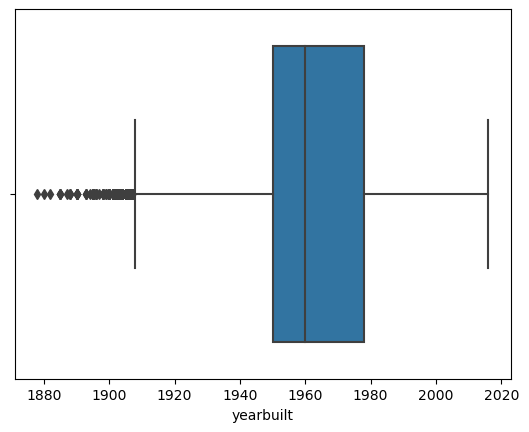

1878       1
1880       1
1882       1
1885       4
1887       1
1888       3
1890       7
1893       3
1894       1
1895      11
1896       5
1897       1
1898       6
1899       3
1900      10
1901      13
1902      13
1903      19
1904      19
1905      58
1906      50
1907      40
1908      60
1909      64
1910     113
1911      93
1912     125
1913      94
1914      71
1915      76
1916      37
1917      43
1918      51
1919      65
1920     169
1921     188
1922     360
1923     506
1924     472
1925     447
1926     382
1927     316
1928     295
1929     229
1930     176
1931     108
1932      75
1933      51
1934      49
1935     110
1936     210
1937     254
1938     339
1939     413
1940     490
1941     491
1942     306
1943     151
1944     309
1945     158
1946     371
1947     976
1948     882
1949     928
1950    1564
1951    1130
1952    1156
1953    1442
1954    1482
1955    1858
1956    1334
1957     972
1958     754
1959    1025
1960     838
1961     786
1962     970

In [20]:
# Create boxplot and value counts of each column
ev.plot_box_value_counts(df)

In [21]:
# split data
train, validate, test = wra.split_data(df)

In [22]:
# show how many rows in each set
print (f'''{train.shape}
{validate.shape}
{test.shape}''')

(29319, 8)
(9773, 8)
(9774, 8)


## Scale Data

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48866 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedroomcnt    48866 non-null  int64  
 1   bathroomcnt   48866 non-null  float64
 2   finished_sf   48866 non-null  int64  
 3   taxvalue      48866 non-null  int64  
 4   garagecarcnt  48866 non-null  int64  
 5   lotsize_sf    48866 non-null  int64  
 6   yearbuilt     48866 non-null  int64  
 7   county        48866 non-null  object 
dtypes: float64(1), int64(6), object(1)
memory usage: 3.4+ MB


In [24]:
# scaled the data
train_scaled, validate_scaled, test_scaled = exp.scale_data(train, validate, test, to_scale=['bedroomcnt', 'bathroomcnt', 'finished_sf', 'garagecarcnt', 'lotsize_sf', 'yearbuilt'])

In [25]:
# this is what scaled looks like
train_scaled

,bedroomcnt,bathroomcnt,finished_sf,garagecarcnt,lotsize_sf,yearbuilt
0,0.272727,0.2500,0.184187,0.222222,0.084680,0.557971
1,0.272727,0.3125,0.362120,0.333333,0.075551,0.876812
2,0.272727,0.2500,0.223049,0.000000,0.096235,0.623188
3,0.363636,0.3750,0.383562,0.222222,0.166176,0.797101
4,0.272727,0.2500,0.230941,0.000000,0.084054,0.521739
...,...,...,...,...,...,...
29314,0.181818,0.2500,0.139815,0.000000,0.682521,0.362319
29315,0.363636,0.3750,0.329065,0.000000,0.093850,0.688406
29316,0.181818,0.1250,0.081894,0.000000,0.063437,0.318841
29317,0.272727,0.3750,0.315366,0.222222,0.089558,0.623188


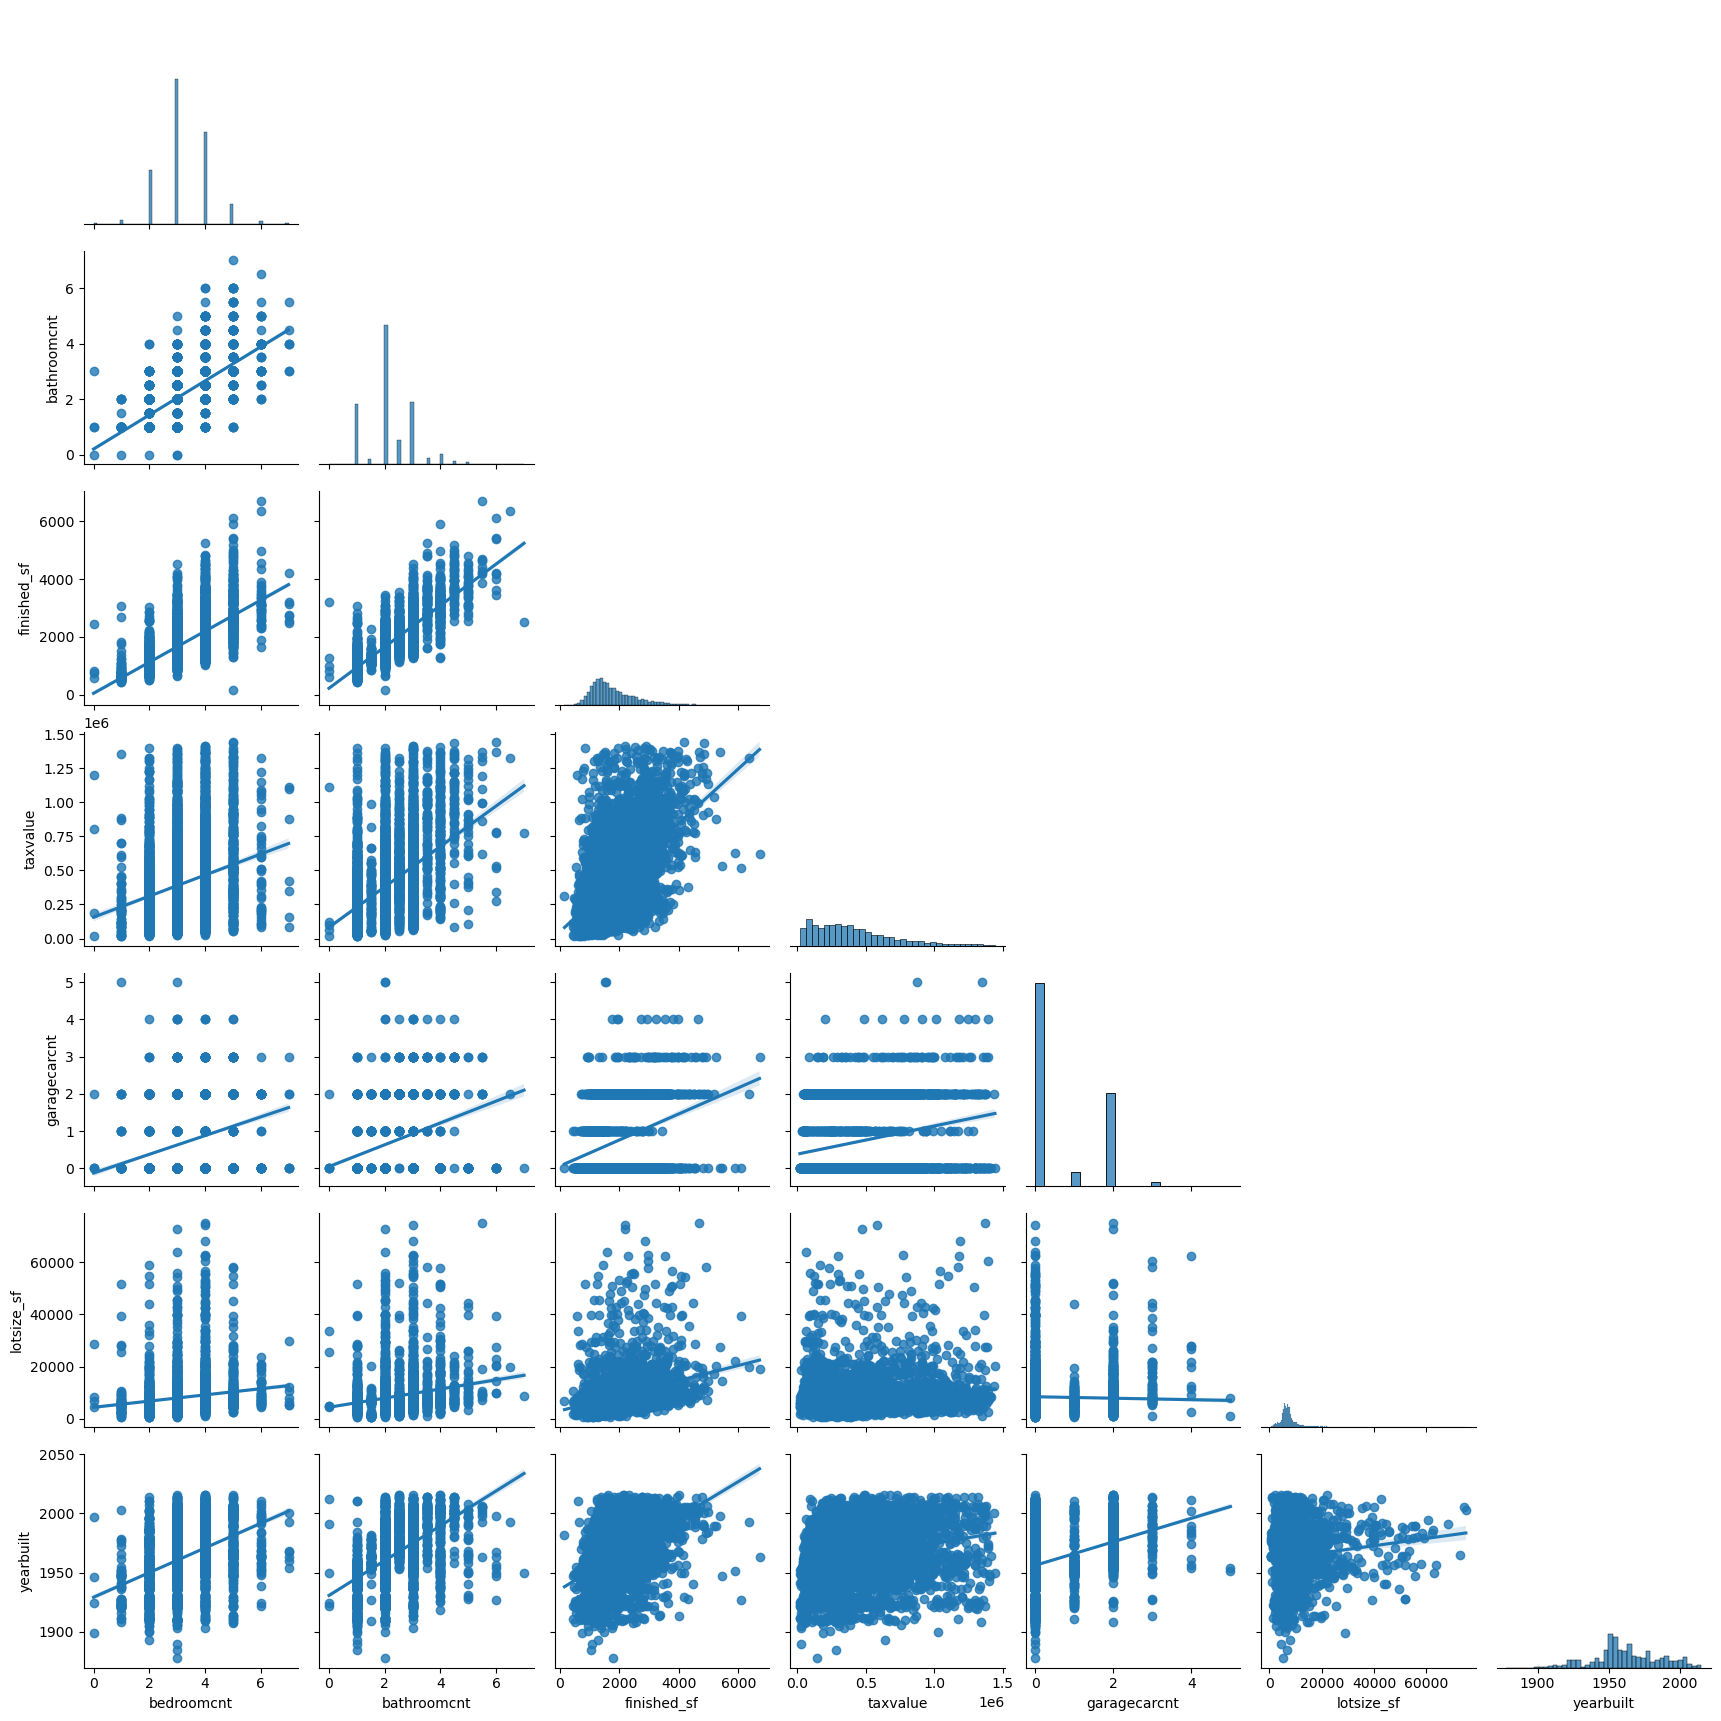

In [26]:
sns.pairplot(train.sample(5000), corner=True, kind='reg')
plt.show()

In [ ]:
# exp.plot_categorical_and_continuous_vars(train, 'taxvalue', 'bedroomcnt')

In [ ]:
# exp.plot_variable_pairs(train)

## Explore

### Does lotsize_sf correlate with taxvalue?

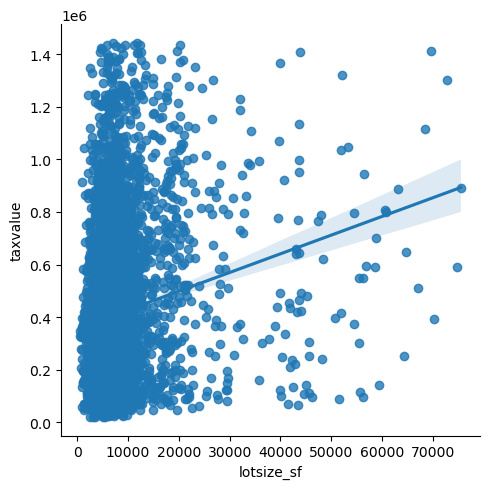

In [30]:
ev.lotsize_plot_lmplot(train)

* In pearsonr The p-value measures the probability of observing a correlation coefficient. A p-value of less than 0.05 is often used as a threshold for statistical significance, indicating that the correlation coefficient is unlikely to have occurred by chance.

* H0 = There is no relationship between taxvalue and lotsize_sf
* Ha = There is a relationship between taxvalue and lotsize_sf

In [32]:
ev.lotsize_pearson_corr(train)

Pearson correlation coefficient: 0.150
P-value: 0.000


* The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is evidence of correlation between lotsize_sf and taxvalue. We will send it on to modeling.

### Does finished_sf correlate with taxvalue?

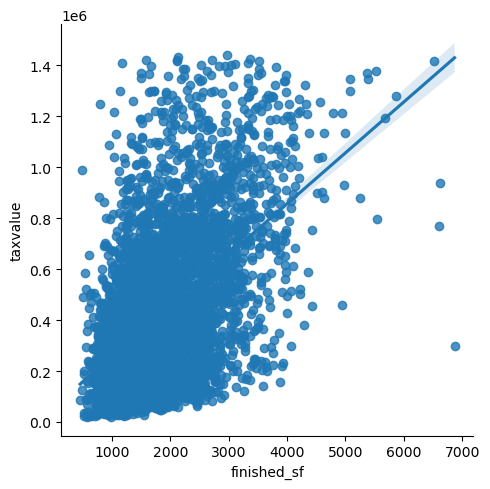

In [34]:
train_sample = train.sample(n=5000, random_state=42)
sns.lmplot(x='finished_sf', y='taxvalue', data=train.sample(5000))
plt.show()

* In pearsonr The p-value measures the probability of observing a correlation coefficient. A p-value of less than 0.05 is often used as a threshold for statistical significance, indicating that the correlation coefficient is unlikely to have occurred by chance.

* H0 = There is no relationship between taxvalue and finished_sf
* Ha = There is a relationship between taxvalue and finished_sf

In [35]:
# Calculate the Pearson correlation coefficient and p-value
corr, pval = stat.pearsonr(train['lotsize_sf'], train['taxvalue'])

# Print the correlation coefficient and p-value
print(f"Pearson correlation coefficient: {corr:.3f}")
print(f"P-value: {pval:.3f}")

Pearson correlation coefficient: 0.150
P-value: 0.000


* The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is evidence of correlation between finished_sf and taxvalue. We will send it on to modeling.

### Is there significance in the means for bedroomcnt and taxvalue?

<Figure size 1800x1000 with 0 Axes>

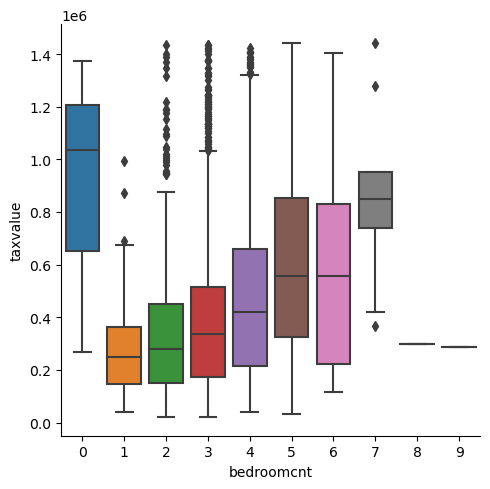

In [36]:
plt.figure(figsize=(18, 10))
train_sample2 = train.sample(n=5000, random_state=42)
bedroom_order = sorted(train_sample2['bedroomcnt'].unique())
sns.catplot(x='bedroomcnt', y='taxvalue', data=train_sample2, kind='box', order=bedroom_order)
plt.show()

* In the visual beyond the 0 bedroom flats there is a positive correlation.

In [37]:
# Convert the 'bedroomcnt' column to categorical
train['bedroomcnt'] = train['bedroomcnt'].astype(str)

# Perform the ANOVA test
result = stat.f_oneway(train[train['bedroomcnt'] == '0']['taxvalue'], 
                         train[train['bedroomcnt'] == '1']['taxvalue'], 
                         train[train['bedroomcnt'] == '2']['taxvalue'], 
                         train[train['bedroomcnt'] == '3']['taxvalue'], 
                         train[train['bedroomcnt'] == '4']['taxvalue'], 
                         train[train['bedroomcnt'] == '5']['taxvalue'], 
                         train[train['bedroomcnt'] == '6']['taxvalue'], 
                         train[train['bedroomcnt'] == '7']['taxvalue'], 
                         train[train['bedroomcnt'] == '8']['taxvalue'], 
                         train[train['bedroomcnt'] == '9']['taxvalue'])

# Print the results
print("F-statistic:", result[0])
print("P-value:", result[1])

F-statistic: 248.82254734849317
P-value: 0.0


* The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is significance in the means for bedroomcnt and taxvalue. We will send it on to modeling.

### Is there significance in the means for garagecarcnt and taxvalue?

<Figure size 1800x1000 with 0 Axes>

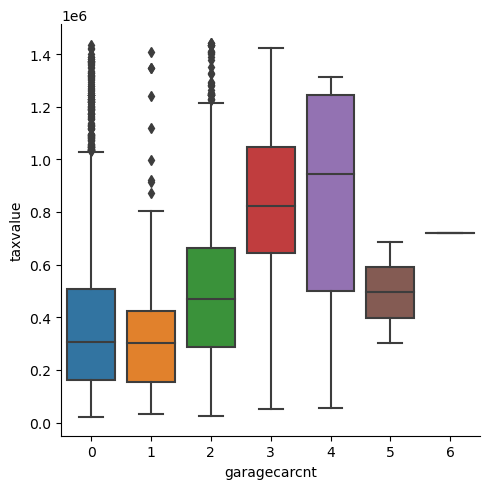

In [38]:
plt.figure(figsize=(18, 10))
train_sample2 = train.sample(n=5000, random_state=42)
bedroom_order = sorted(train_sample2['garagecarcnt'].unique())
sns.catplot(x='garagecarcnt', y='taxvalue', data=train_sample2, kind='box', order=bedroom_order)
plt.show()

* In the visual beyond the 0-1 car garage there is a positive correlation up to four car garage.

In [39]:
# perform ANOVA test
f_statistic, p_value = stat.f_oneway(train['taxvalue'][train['garagecarcnt'] == 0],
                                      train['taxvalue'][train['garagecarcnt'] == 1],
                                      train['taxvalue'][train['garagecarcnt'] == 2],
                                      train['taxvalue'][train['garagecarcnt'] == 3],
                                      train['taxvalue'][train['garagecarcnt'] == 4],
                                      train['taxvalue'][train['garagecarcnt'] == 5])

# print the results
print('F-Statistic:', f_statistic)
print('P-Value:', p_value)

F-Statistic: 340.47781003748173
P-Value: 0.0


* The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is significance in the means for garagecnt and taxvalue. We will send it on to modeling.

### Exploration Summary

* The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is evidence of correlation between lotsize_sf and taxvalue. 
* The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is evidence of correlation between finished_sf and taxvalue.
* The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is significance in the means for bedroomcnt and taxvalue. 
* The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is significance in the means for garagecnt and taxvalue.

### Features I will model
* bedroomcnt, bathroomcnt, finished_sf, garagecarcnt, lotsize_sf, yearbuilt

### Modeling

In [40]:
train = train.drop('county', axis=1)
validate = validate.drop('county', axis=1)
test = test.drop('county', axis=1)

In [41]:
X_train, X_validate, X_test, y_train, y_validate, y_test = wra.get_X_train_val_test(train, validate, test, 'taxvalue', 'taxvalue')

In [42]:
type(X_train)

pandas.core.frame.DataFrame

In [43]:
X_train_scaled, X_validate_scaled, X_test_scaled = wra.scaled_data_to_dataframe(X_train, X_validate, X_test)

In [44]:
X_train_scaled

,bedroomcnt,bathroomcnt,finished_sf,garagecarcnt,lotsize_sf,yearbuilt
0,0.0,0.0,-0.243272,1.0,0.029310,-0.178571
1,0.0,0.5,1.043057,1.5,-0.206897,1.392857
2,0.0,0.0,0.037675,0.0,0.328276,0.142857
3,1.0,1.0,1.198062,1.0,2.137931,1.000000
4,0.0,0.0,0.094726,0.0,0.013103,-0.357143
...,...,...,...,...,...,...
29314,-1.0,0.0,-0.564047,0.0,15.497931,-1.142857
29315,1.0,1.0,0.804090,0.0,0.266552,0.464286
29316,-1.0,-1.0,-0.982777,0.0,-0.520345,-1.357143
29317,0.0,1.0,0.705059,1.0,0.155517,0.142857


In [45]:
#create baseline of y-target
baseline = train.taxvalue.mean()
baseline

411554.00740134384

In [46]:
# make it
lr = LinearRegression()

# fit it to training data
lr.fit(X_train_scaled, y_train)

# use it
# we will use lr.predict to make predictions 
yhat = lr.predict(X_train_scaled)

In [47]:
ev.metrics_reg(y_train, yhat)

(244858.61160103814, 0.30659284134594655)

In [48]:
baseline_array = np.repeat(baseline, len(train))
baseline_array[:5]

array([411554.00740134, 411554.00740134, 411554.00740134, 411554.00740134,
       411554.00740134])

In [50]:
rmse, r2 = ev.metrics_reg(y_train, baseline_array)
rmse, r2

(294050.0260077784, 0.0)

In [51]:
# we will use this metrics df to feed the different models in so we can see their performance side by side
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics_df

,model,rmse,r2
0,baseline,294050.026008,0.0


### Ordinary Least Squares

In [52]:
#intial ML model
lr1 = LinearRegression()

#make it
rfe = RFE(lr1, n_features_to_select=4)

#fit it
rfe.fit(X_train, y_train)

#use it on train
X_train_rfe = rfe.transform(X_train)

#use it on validate
X_val_rfe = rfe.transform(X_validate)

In [53]:
print('selected top feature:', rfe.get_feature_names_out())

selected top feature: ['bedroomcnt' 'bathroomcnt' 'garagecarcnt' 'yearbuilt']


In [54]:
#fit the thing
lr1.fit(X_train_rfe, y_train)

#use the thing (make predictions)
pred_lr1 = lr1.predict(X_train_rfe)
pred_val_lr1 = lr1.predict(X_val_rfe)

In [55]:
pred_lr1[:10]

array([441990.903003  , 538897.1556417 , 356168.11635538, 568938.8279606 ,
       364780.22548573, 531209.25607147, 363549.92418139, 336986.98224878,
       560941.86948242, 242753.50574548])

In [57]:
#train
ev.metrics_reg(y_train, pred_lr1)

(258955.10378642697, 0.22445588667726257)

In [59]:
#validate
rmse, r2 = ev.metrics_reg(y_validate, pred_val_lr1)
rmse, r2

(254212.5470861422, 0.2369224591523268)

In [60]:
#add to my metrics df
metrics_df.loc[1] = ['ols_1', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,294050.026008,0.000000
1,ols_1,254212.547086,0.236922


In [61]:
lr1.intercept_

1290239.6396660795

In [62]:
lr1.coef_

array([-20411.43541093, 167659.33189008,  40143.21538906,   -615.15065217])

### Multiple Regression

In [64]:
#make it
lr2 = LinearRegression()

#fit it on our RFE features
lr2.fit(X_train, y_train)

#use it (make predictions)
pred_lr2 = lr2.predict(X_train)

#use it on validate
pred_val_lr2 = lr2.predict(X_validate)

In [65]:
pred_lr2[:10]

array([381381.05441517, 647070.86545109, 363330.46387108, 614734.39497863,
       386520.07361928, 549856.5633011 , 266342.43036596, 269566.03167017,
       654405.92171603, 595220.39313152])

In [67]:
#train 
ev.metrics_reg(y_train, pred_lr2)

(244858.61160103814, 0.30659284134594667)

In [69]:
#validate
rmse, r2 = ev.metrics_reg(y_validate, pred_val_lr2)
rmse, r2

(241563.11030727933, 0.31097348770798394)

In [70]:
#add to my metrics df
metrics_df.loc[2] = ['ols', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,294050.026008,0.000000
1,ols_1,254212.547086,0.236922
2,ols,241563.110307,0.310973


### LassoLars

In [74]:
#make it
lars = LassoLars(alpha=0)

#fit it
lars.fit(X_train, y_train)

#use it
pred_lars = lars.predict(X_train)

In [75]:
pd.Series(lars.coef_, index=lars.feature_names_in_)

bedroomcnt     -53401.329089
bathroomcnt     45845.453761
finished_sf       205.287385
garagecarcnt    31683.896895
lotsize_sf         -1.251241
yearbuilt        -797.553141
dtype: float64

In [76]:
lr2.coef_

array([-5.34013291e+04,  4.58454538e+04,  2.05287385e+02,  3.16838969e+04,
       -1.25124109e+00, -7.97553141e+02])

In [77]:
#make it
lars = LassoLars(alpha=1)

#fit it
lars.fit(X_train, y_train)

#use it
pred_lars = lars.predict(X_train)
pred_val_lars = lars.predict(X_validate)

In [79]:
#train
ev.metrics_reg(y_train, pred_lars)

(244859.450396349, 0.306588090623351)

In [81]:
#validate
rmse, r2 = ev.metrics_reg(y_validate, pred_val_lars)
rmse, r2

(241565.61018755322, 0.31095922648492835)

In [82]:
#add to my metrics df
metrics_df.loc[3] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,294050.026008,0.000000
1,ols_1,254212.547086,0.236922
2,ols,241563.110307,0.310973
3,lars,241565.610188,0.310959


### Polynomial Regression

In [83]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [84]:
#make it
pr = LinearRegression()

#fit it
pr.fit(X_train_degree2, y_train)

#use it
pred_pr = pr.predict(X_train_degree2)
pred_val_pr = pr.predict(X_validate_degree2)

In [86]:
#train
ev.metrics_reg(y_train, pred_pr)

(239483.22211955252, 0.33670344584903844)

In [88]:
#validate
rmse, r2 = ev.metrics_reg(y_validate, pred_val_pr)
rmse, r2

(235795.84450834908, 0.34348145010002096)

In [89]:
#add to my metrics df
metrics_df.loc[4] = ['poly_2', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,294050.026008,0.000000
1,ols_1,254212.547086,0.236922
2,ols,241563.110307,0.310973
3,lars,241565.610188,0.310959
4,poly_2,235795.844508,0.343481


### Generalized Linear Model (GLM)

In [90]:
#make it
glm = TweedieRegressor(power=1, alpha=0)

#fit it
glm.fit(X_train, y_train)

#use it
pred_glm = glm.predict(X_train)
pred_val_glm = glm.predict(X_validate)

In [92]:
#train
ev.metrics_reg(y_train, pred_glm)

(294050.0260077784, 0.0)

In [94]:
#validate
rmse, r2 = ev.metrics_reg(y_validate, pred_val_glm)
rmse, r2

(291049.4128510445, -0.0002490838689561681)

In [95]:
metrics_df.loc[5] = ['glm',rmse,r2]
metrics_df

,model,rmse,r2
0,baseline,294050.026008,0.000000
1,ols_1,254212.547086,0.236922
2,ols,241563.110307,0.310973
3,lars,241565.610188,0.310959
4,poly_2,235795.844508,0.343481
5,glm,291049.412851,-0.000249


### Evaluate on Best Model

In [96]:
#use it
pred_test = pr.predict(X_test_degree2)
pred_test

array([407501.16311165, 365842.44556537, 277309.81458753, ...,
       296735.19912646, 360490.97555242, 339660.7313671 ])

In [98]:
rmse, r2 = ev.metrics_reg(y_test, pred_test)
rmse, r2

(241377.3892006518, 0.3360835106741108)

In [99]:
metrics_df.loc[6] = ['test',rmse,r2]
metrics_df

,model,rmse,r2
0,baseline,294050.026008,0.000000
1,ols_1,254212.547086,0.236922
2,ols,241563.110307,0.310973
3,lars,241565.610188,0.310959
4,poly_2,235795.844508,0.343481
5,glm,291049.412851,-0.000249
6,test,241377.389201,0.336084
